# 🧱 GANs on Bricks Data - Training

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the GAN](#build)
3. [Train the GAN](#train)

In [1]:
%load_ext autoreload
%autoreload 2

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import os

# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Layer, BatchNormalization, LeakyReLU, ReLU, UpSampling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.losses import binary_crossentropy, BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Mean, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img

from utils.image import preprocess, display
from utils.datasets import sample_batches, sample_batch
from utils.losses import root_mean_squared_error

## 0. Parameters <a name="parameters"></a>

In [50]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1=0.5
ADAM_BETA_2=0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.5

## 1. Prepare the data <a name="prepare"></a>

In [4]:
train_data = image_dataset_from_directory(
    "/app/data/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.
Using 32000 files for training.


2022-04-24 06:30:37.778437: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 40000 files belonging to 1 classes.
Using 8000 files for validation.


In [5]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img

train = train_data.map(lambda x: preprocess(x))

In [6]:
train_sample = sample_batch(train)

In [7]:
display(train_sample)

AttributeError: 'MapDataset' object has no attribute 'max'

## 2. Build the GAN <a name="build"></a>

In [8]:
discriminator_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias = False)(discriminator_input)
x = LeakyReLU(0.2)(x)
x = Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum = 0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum = 0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum = 0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(1, kernel_size=4, strides=1, padding="valid", use_bias = False, activation = 'sigmoid')(x)
discriminator_output = Flatten()(x)

discriminator = Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                             

In [9]:
generator_input = Input(shape=(Z_DIM,))
x = Reshape((1, 1, Z_DIM))(generator_input)
x = Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias = False)(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
generator_output = Conv2DTranspose(1, kernel_size=4, strides=2, padding="same", use_bias = False, activation = 'tanh')(x)
generator = Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

In [10]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = BinaryCrossentropy()
        self.d_loss_metric = Mean(name="d_loss")
        self.d_real_acc_metric = BinaryAccuracy()
        self.d_fake_acc_metric = BinaryAccuracy()
        self.d_acc_metric = BinaryAccuracy()
        self.g_loss_metric = Mean(name="g_loss")
        self.g_acc_metric = BinaryAccuracy()

    @property
    def metrics(self):
        return [self.d_loss_metric, self.d_acc_metric, self.g_loss_metric, self.g_acc_metric]
    
    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            generated_images = self.generator(random_latent_vectors, training = True)
            real_predictions = self.discriminator(real_images, training = True)
            fake_predictions = self.discriminator(generated_images, training = True)
            
            real_labels = tf.zeros_like(real_predictions)
            fake_labels = tf.ones_like(fake_predictions)
            
            d_real_loss = self.loss_fn(real_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0
            
            g_loss = self.loss_fn(real_labels, fake_predictions)
            
        
        gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)

        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state([real_labels, fake_labels], [real_predictions, fake_predictions])
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)
        
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [78]:
np.random.uniform(-0.5,0.5)

0.1412621054411064

## 3. Train the GAN <a name="train"></a>

In [11]:
#Create a GAN
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=Z_DIM)

In [12]:
gan.compile(
    d_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1 = ADAM_BETA_1, beta_2 = ADAM_BETA_2),
    g_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1 = ADAM_BETA_1, beta_2 = ADAM_BETA_2),
)

In [13]:
# Create a model save checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = TensorBoard(log_dir="./logs2")

class ImageGenerator(Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch))
        


Epoch 165/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1016 - g_loss: 7.6978
Saved to ./output/generated_img_164.png


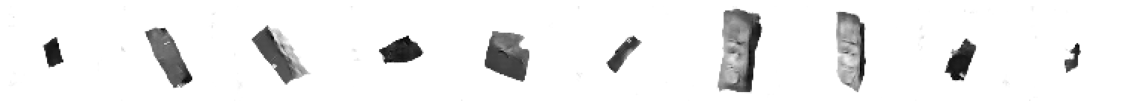

250/250 [==============================] - 39s 151ms/step - d_loss: 0.1016 - g_loss: 7.6978
Epoch 166/300
250/250 [==============================] - ETA: 0s - d_loss: 0.2701 - g_loss: 7.1954
Saved to ./output/generated_img_165.png


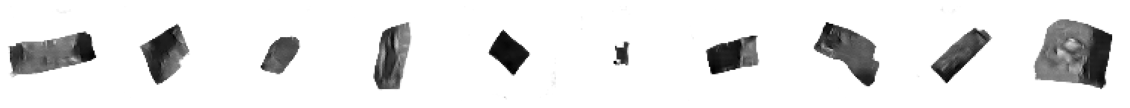

250/250 [==============================] - 38s 147ms/step - d_loss: 0.2701 - g_loss: 7.1954
Epoch 167/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1179 - g_loss: 7.5201
Saved to ./output/generated_img_166.png


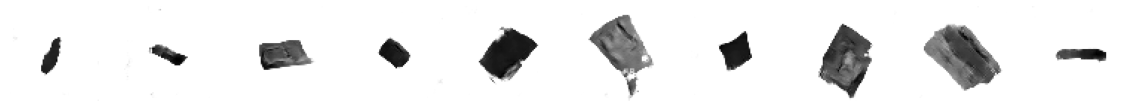

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1179 - g_loss: 7.5201
Epoch 168/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0824 - g_loss: 7.7126
Saved to ./output/generated_img_167.png


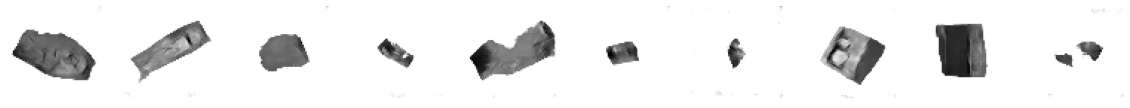

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0824 - g_loss: 7.7126
Epoch 169/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1170 - g_loss: 7.7284
Saved to ./output/generated_img_168.png


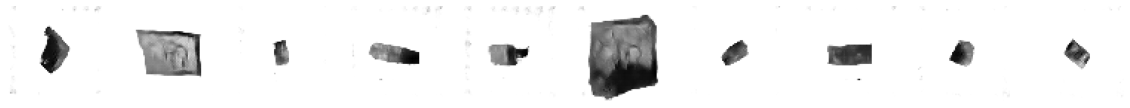

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1170 - g_loss: 7.7284
Epoch 170/300
250/250 [==============================] - ETA: 0s - d_loss: 0.2487 - g_loss: 7.5770
Saved to ./output/generated_img_169.png


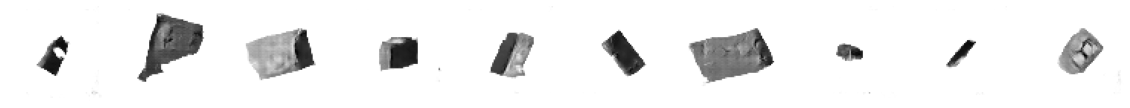

250/250 [==============================] - 38s 148ms/step - d_loss: 0.2487 - g_loss: 7.5770
Epoch 171/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1463 - g_loss: 7.3540
Saved to ./output/generated_img_170.png


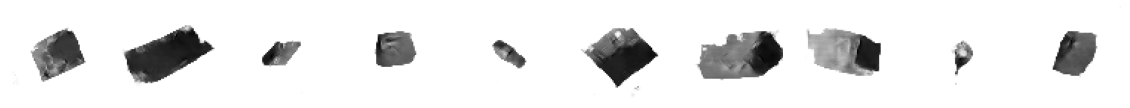

250/250 [==============================] - 38s 149ms/step - d_loss: 0.1463 - g_loss: 7.3540
Epoch 172/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0962 - g_loss: 7.7527
Saved to ./output/generated_img_171.png


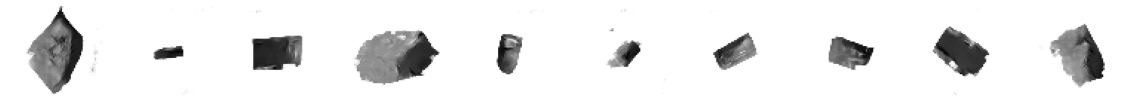

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0962 - g_loss: 7.7527
Epoch 173/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1039 - g_loss: 7.7123
Saved to ./output/generated_img_172.png


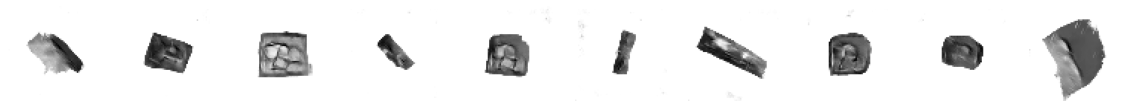

250/250 [==============================] - 38s 149ms/step - d_loss: 0.1039 - g_loss: 7.7123
Epoch 174/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1959 - g_loss: 7.5586
Saved to ./output/generated_img_173.png


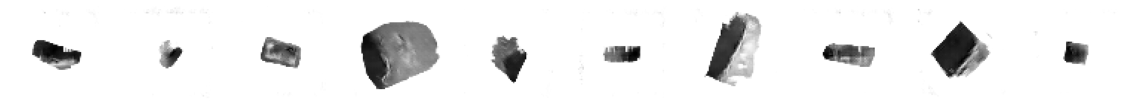

250/250 [==============================] - 38s 147ms/step - d_loss: 0.1959 - g_loss: 7.5586
Epoch 175/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0908 - g_loss: 7.7483
Saved to ./output/generated_img_174.png


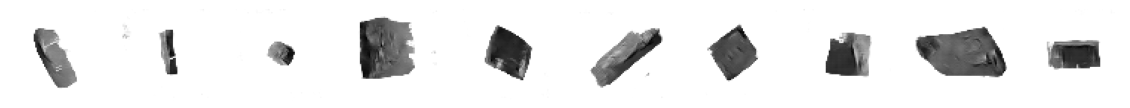

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0908 - g_loss: 7.7483
Epoch 176/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0918 - g_loss: 8.0448
Saved to ./output/generated_img_175.png


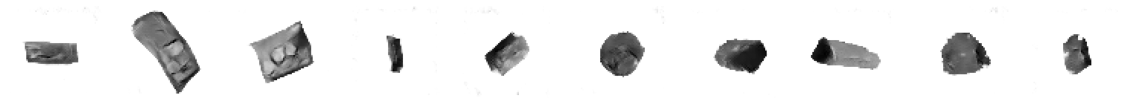

250/250 [==============================] - 38s 149ms/step - d_loss: 0.0918 - g_loss: 8.0448
Epoch 177/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1134 - g_loss: 8.3050
Saved to ./output/generated_img_176.png


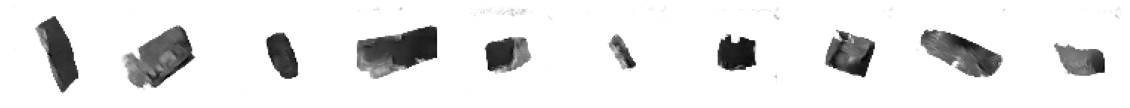

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1134 - g_loss: 8.3050
Epoch 178/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1734 - g_loss: 7.7536
Saved to ./output/generated_img_177.png


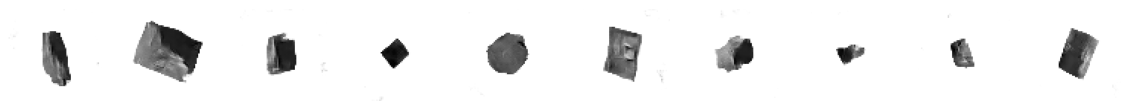

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1734 - g_loss: 7.7536
Epoch 179/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1347 - g_loss: 7.6235
Saved to ./output/generated_img_178.png


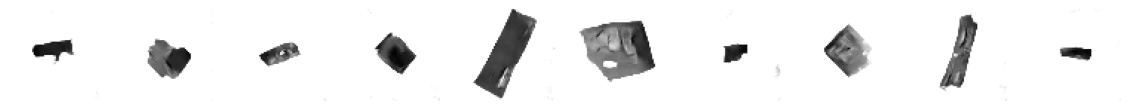

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1347 - g_loss: 7.6235
Epoch 180/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0559 - g_loss: 8.2190
Saved to ./output/generated_img_179.png


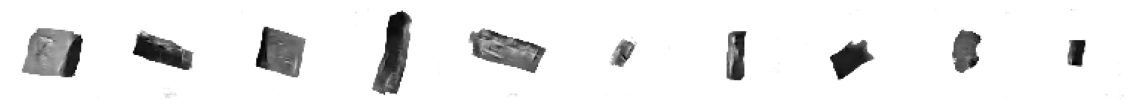

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0559 - g_loss: 8.2190
Epoch 181/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1545 - g_loss: 7.9871
Saved to ./output/generated_img_180.png


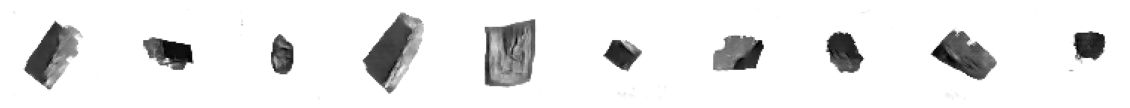

250/250 [==============================] - 38s 149ms/step - d_loss: 0.1545 - g_loss: 7.9871
Epoch 182/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1157 - g_loss: 7.9450
Saved to ./output/generated_img_181.png


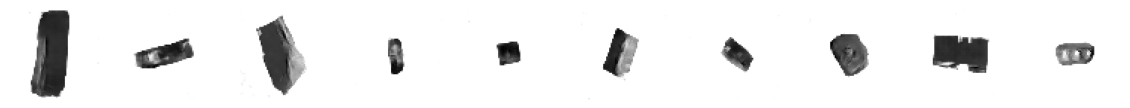

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1157 - g_loss: 7.9450
Epoch 183/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0830 - g_loss: 8.1348
Saved to ./output/generated_img_182.png


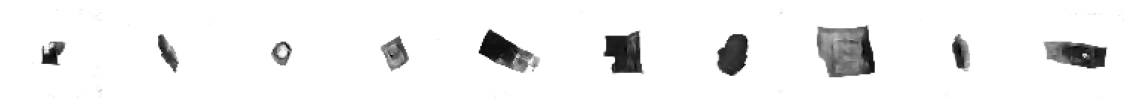

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0830 - g_loss: 8.1348
Epoch 184/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0921 - g_loss: 8.1541
Saved to ./output/generated_img_183.png


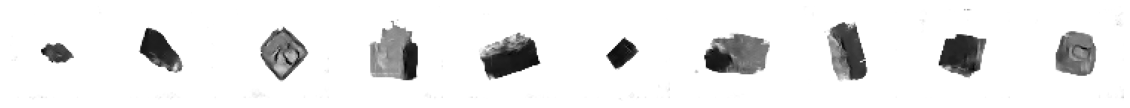

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0921 - g_loss: 8.1541
Epoch 185/300
250/250 [==============================] - ETA: 0s - d_loss: 0.3098 - g_loss: 7.5769
Saved to ./output/generated_img_184.png


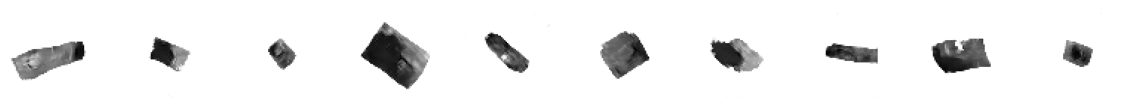

250/250 [==============================] - 38s 147ms/step - d_loss: 0.3098 - g_loss: 7.5769
Epoch 186/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1210 - g_loss: 7.4428
Saved to ./output/generated_img_185.png


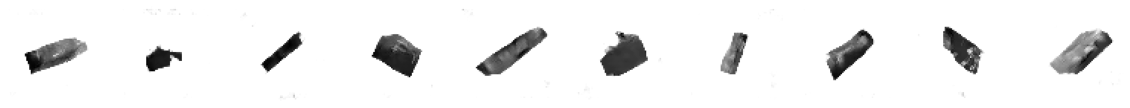

250/250 [==============================] - 38s 149ms/step - d_loss: 0.1210 - g_loss: 7.4428
Epoch 187/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1184 - g_loss: 7.9973
Saved to ./output/generated_img_186.png


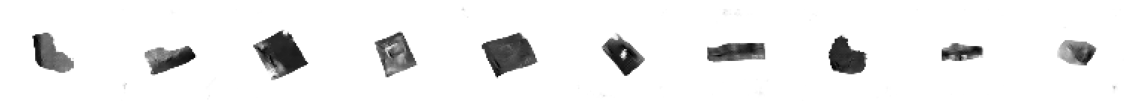

250/250 [==============================] - 38s 149ms/step - d_loss: 0.1184 - g_loss: 7.9973
Epoch 188/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0937 - g_loss: 8.1800
Saved to ./output/generated_img_187.png


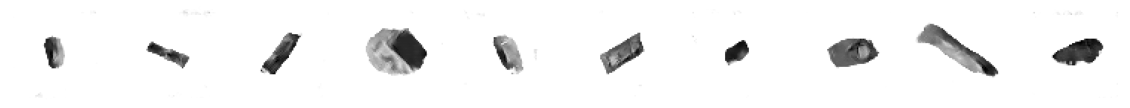

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0937 - g_loss: 8.1800
Epoch 189/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0791 - g_loss: 8.1253
Saved to ./output/generated_img_188.png


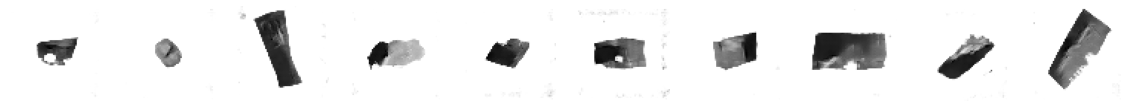

250/250 [==============================] - 38s 149ms/step - d_loss: 0.0791 - g_loss: 8.1253
Epoch 190/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1242 - g_loss: 8.1605
Saved to ./output/generated_img_189.png


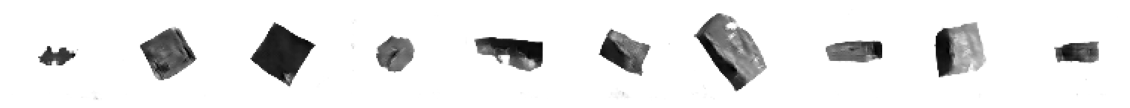

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1242 - g_loss: 8.1605
Epoch 191/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1604 - g_loss: 8.0882
Saved to ./output/generated_img_190.png


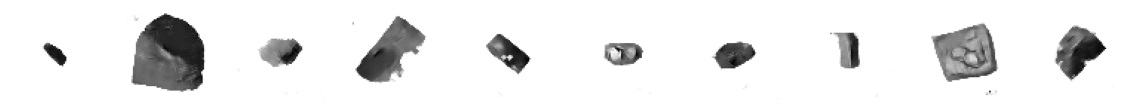

250/250 [==============================] - 38s 149ms/step - d_loss: 0.1604 - g_loss: 8.0882
Epoch 192/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0737 - g_loss: 8.2918
Saved to ./output/generated_img_191.png


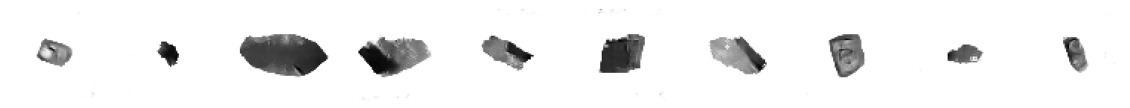

250/250 [==============================] - 38s 149ms/step - d_loss: 0.0737 - g_loss: 8.2918
Epoch 193/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0939 - g_loss: 8.3083
Saved to ./output/generated_img_192.png


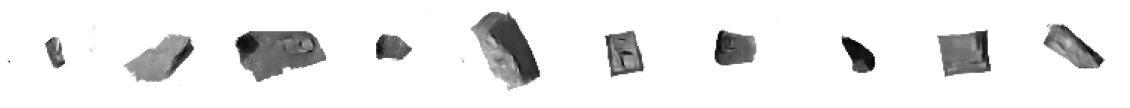

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0939 - g_loss: 8.3083
Epoch 194/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1251 - g_loss: 8.5463
Saved to ./output/generated_img_193.png


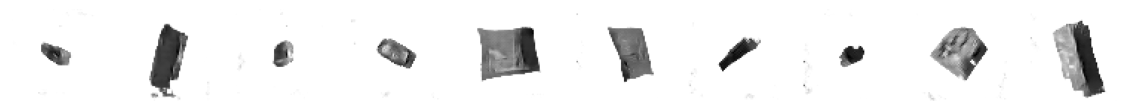

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1251 - g_loss: 8.5463
Epoch 195/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1397 - g_loss: 7.9715
Saved to ./output/generated_img_194.png


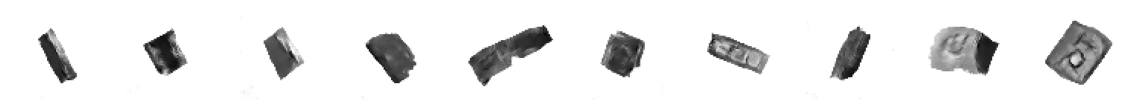

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1397 - g_loss: 7.9715
Epoch 196/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0797 - g_loss: 8.4287
Saved to ./output/generated_img_195.png


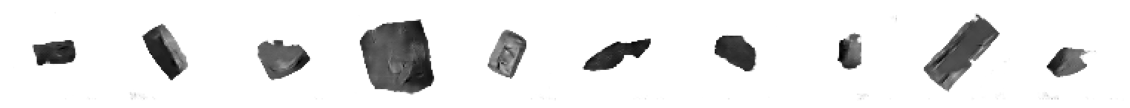

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0797 - g_loss: 8.4287
Epoch 197/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1053 - g_loss: 8.3885
Saved to ./output/generated_img_196.png


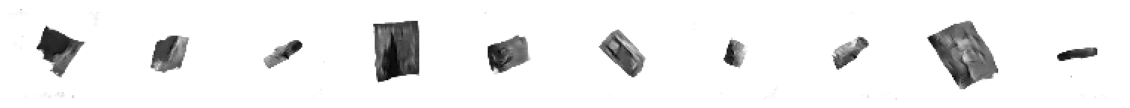

250/250 [==============================] - 38s 149ms/step - d_loss: 0.1053 - g_loss: 8.3885
Epoch 198/300
250/250 [==============================] - ETA: 0s - d_loss: 0.3621 - g_loss: 7.8609
Saved to ./output/generated_img_197.png


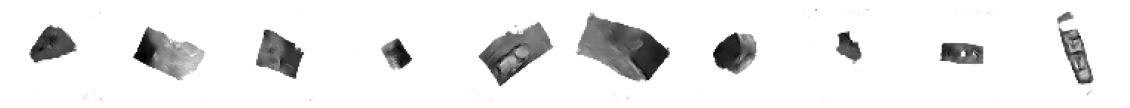

250/250 [==============================] - 38s 148ms/step - d_loss: 0.3621 - g_loss: 7.8609
Epoch 199/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0894 - g_loss: 8.0336
Saved to ./output/generated_img_198.png


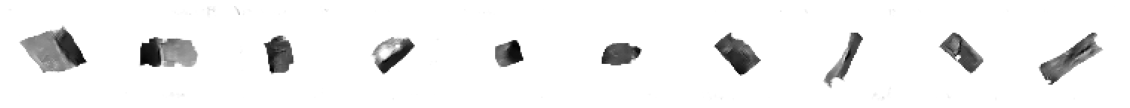

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0894 - g_loss: 8.0336
Epoch 200/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0989 - g_loss: 8.4112
Saved to ./output/generated_img_199.png


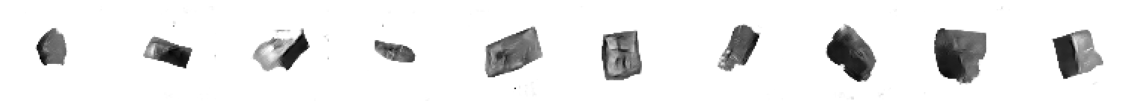

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0989 - g_loss: 8.4112
Epoch 201/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0619 - g_loss: 8.6255
Saved to ./output/generated_img_200.png


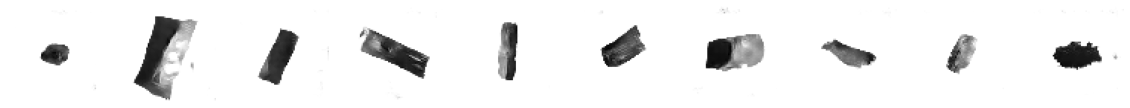

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0619 - g_loss: 8.6255
Epoch 202/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0856 - g_loss: 8.4979
Saved to ./output/generated_img_201.png


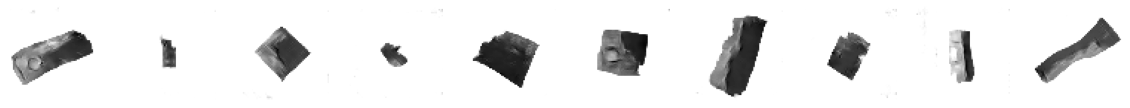

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0856 - g_loss: 8.4979
Epoch 203/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0493 - g_loss: 8.8921
Saved to ./output/generated_img_202.png


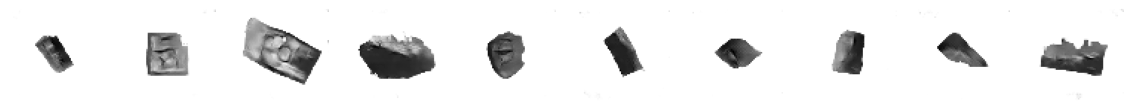

250/250 [==============================] - 38s 149ms/step - d_loss: 0.0493 - g_loss: 8.8921
Epoch 204/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0832 - g_loss: 8.8504
Saved to ./output/generated_img_203.png


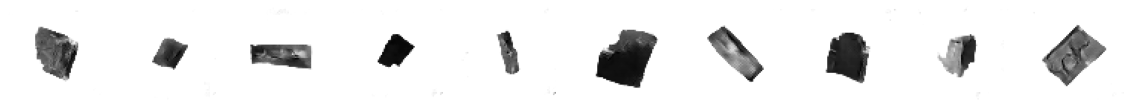

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0832 - g_loss: 8.8504
Epoch 205/300
250/250 [==============================] - ETA: 0s - d_loss: 0.3073 - g_loss: 7.9077
Saved to ./output/generated_img_204.png


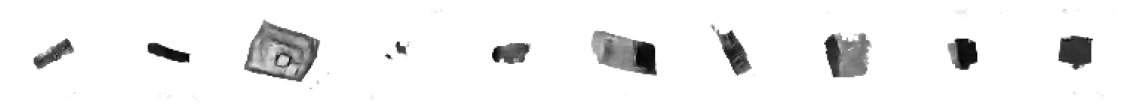

250/250 [==============================] - 38s 148ms/step - d_loss: 0.3073 - g_loss: 7.9077
Epoch 206/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0807 - g_loss: 8.5647
Saved to ./output/generated_img_205.png


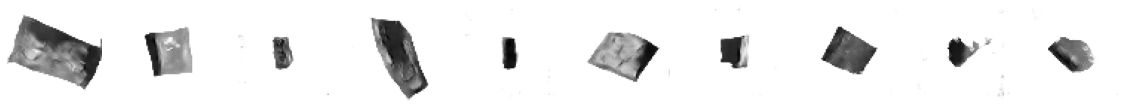

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0807 - g_loss: 8.5647
Epoch 207/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0617 - g_loss: 8.9281
Saved to ./output/generated_img_206.png


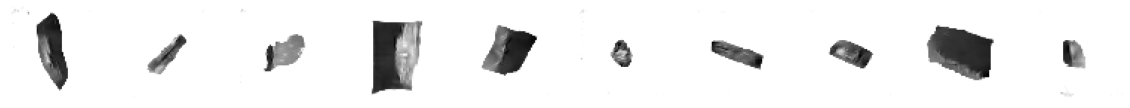

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0617 - g_loss: 8.9281
Epoch 208/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0726 - g_loss: 8.8561
Saved to ./output/generated_img_207.png


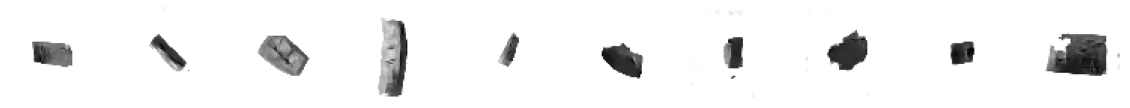

250/250 [==============================] - 38s 149ms/step - d_loss: 0.0726 - g_loss: 8.8561
Epoch 209/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0919 - g_loss: 8.7063
Saved to ./output/generated_img_208.png


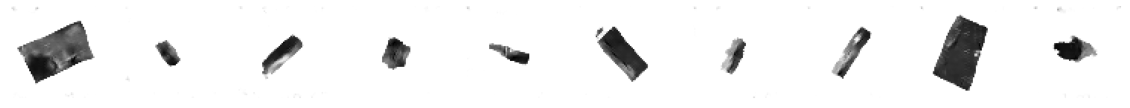

250/250 [==============================] - 38s 147ms/step - d_loss: 0.0919 - g_loss: 8.7063
Epoch 210/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0920 - g_loss: 8.9294
Saved to ./output/generated_img_209.png


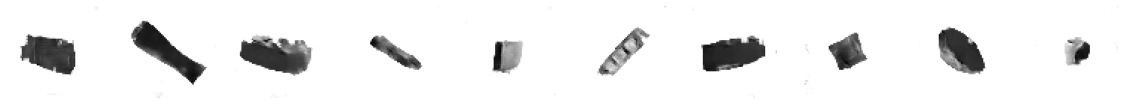

250/250 [==============================] - 38s 149ms/step - d_loss: 0.0920 - g_loss: 8.9294
Epoch 211/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1057 - g_loss: 8.4976
Saved to ./output/generated_img_210.png


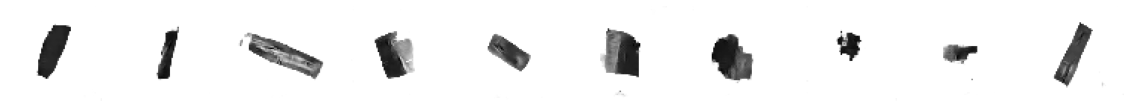

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1057 - g_loss: 8.4976
Epoch 212/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0756 - g_loss: 8.9928
Saved to ./output/generated_img_211.png


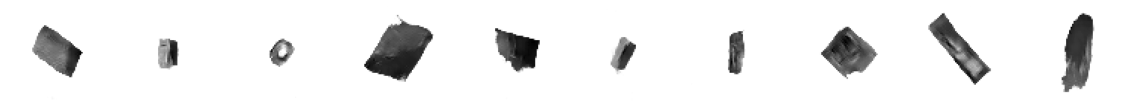

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0756 - g_loss: 8.9928
Epoch 213/300
250/250 [==============================] - ETA: 0s - d_loss: 0.2288 - g_loss: 8.2222
Saved to ./output/generated_img_212.png


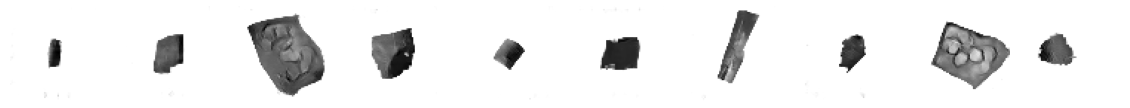

250/250 [==============================] - 38s 149ms/step - d_loss: 0.2288 - g_loss: 8.2222
Epoch 214/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0351 - g_loss: 9.0940
Saved to ./output/generated_img_213.png


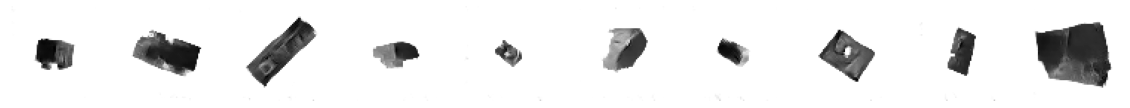

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0351 - g_loss: 9.0940
Epoch 215/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0789 - g_loss: 8.8531
Saved to ./output/generated_img_214.png


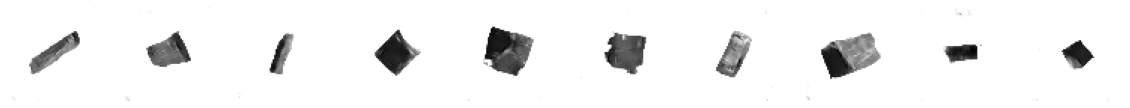

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0789 - g_loss: 8.8531
Epoch 216/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1557 - g_loss: 8.4476
Saved to ./output/generated_img_215.png


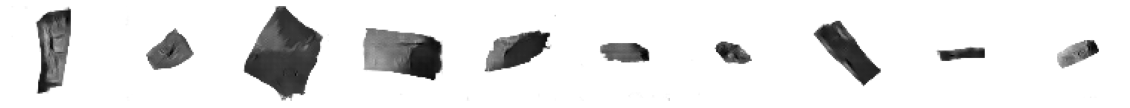

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1557 - g_loss: 8.4476
Epoch 217/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0771 - g_loss: 8.6104
Saved to ./output/generated_img_216.png


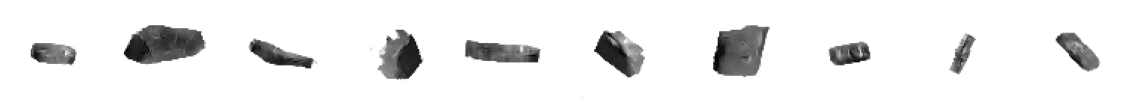

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0771 - g_loss: 8.6104
Epoch 218/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0955 - g_loss: 8.9153
Saved to ./output/generated_img_217.png


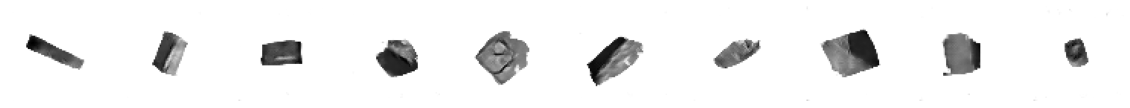

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0955 - g_loss: 8.9153
Epoch 219/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0828 - g_loss: 9.0254
Saved to ./output/generated_img_218.png


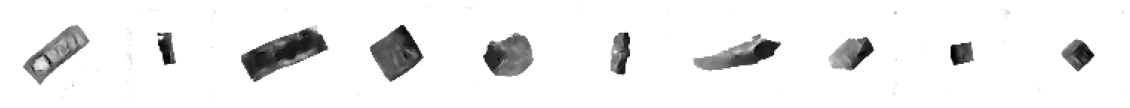

250/250 [==============================] - 38s 149ms/step - d_loss: 0.0828 - g_loss: 9.0254
Epoch 220/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1389 - g_loss: 9.0611
Saved to ./output/generated_img_219.png


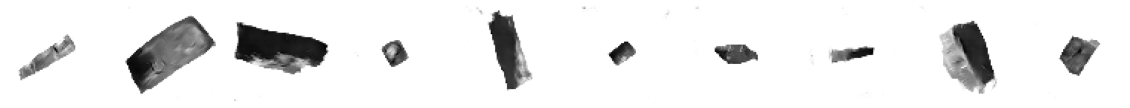

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1389 - g_loss: 9.0611
Epoch 221/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1188 - g_loss: 8.8165
Saved to ./output/generated_img_220.png


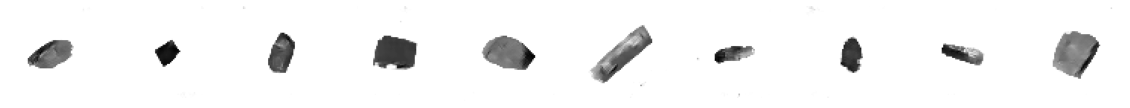

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1188 - g_loss: 8.8165
Epoch 222/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0861 - g_loss: 8.9561
Saved to ./output/generated_img_221.png


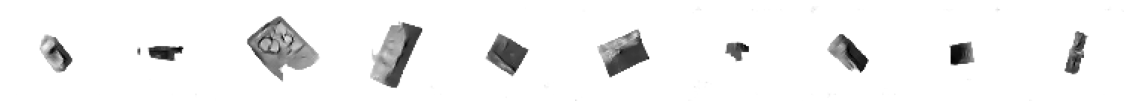

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0861 - g_loss: 8.9561
Epoch 223/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0913 - g_loss: 9.0592
Saved to ./output/generated_img_222.png


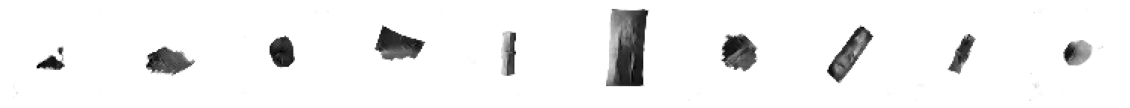

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0913 - g_loss: 9.0592
Epoch 224/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0777 - g_loss: 9.0960
Saved to ./output/generated_img_223.png


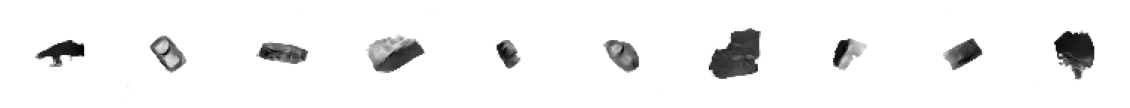

250/250 [==============================] - 38s 149ms/step - d_loss: 0.0777 - g_loss: 9.0960
Epoch 225/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1759 - g_loss: 8.6910
Saved to ./output/generated_img_224.png


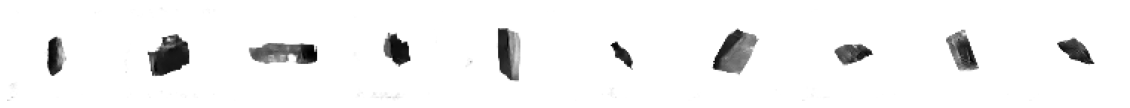

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1759 - g_loss: 8.6910
Epoch 226/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0419 - g_loss: 9.3413
Saved to ./output/generated_img_225.png


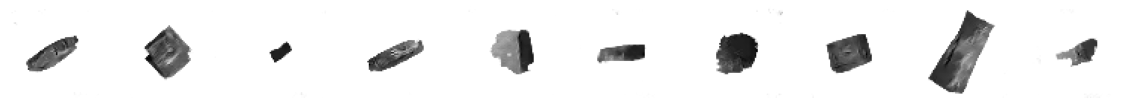

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0419 - g_loss: 9.3413
Epoch 227/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1774 - g_loss: 8.5090
Saved to ./output/generated_img_226.png


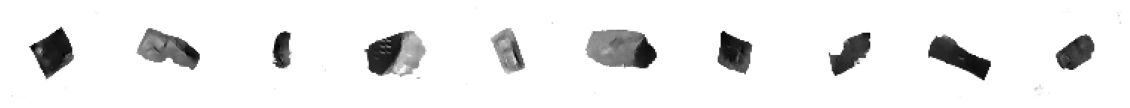

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1774 - g_loss: 8.5090
Epoch 228/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0858 - g_loss: 8.8379
Saved to ./output/generated_img_227.png


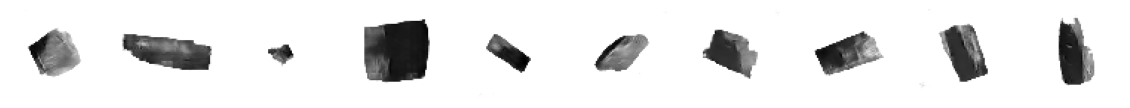

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0858 - g_loss: 8.8379
Epoch 229/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0983 - g_loss: 9.0551
Saved to ./output/generated_img_228.png


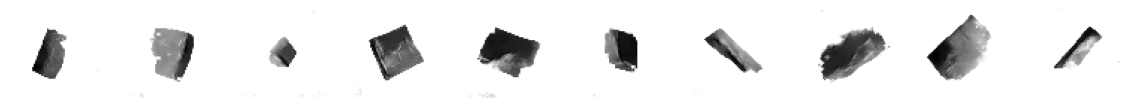

250/250 [==============================] - 38s 150ms/step - d_loss: 0.0983 - g_loss: 9.0551
Epoch 230/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0992 - g_loss: 9.0769
Saved to ./output/generated_img_229.png


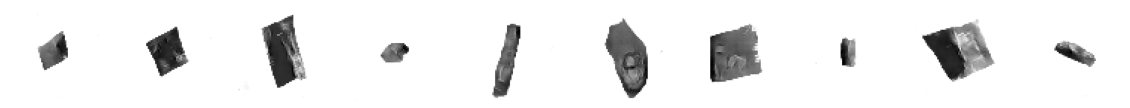

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0992 - g_loss: 9.0769
Epoch 231/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1008 - g_loss: 9.3410
Saved to ./output/generated_img_230.png


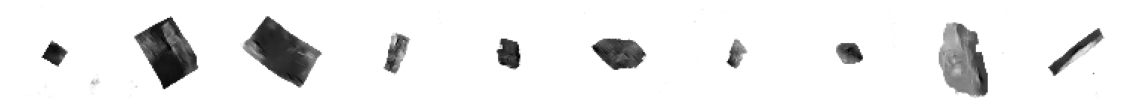

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1008 - g_loss: 9.3410
Epoch 232/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0889 - g_loss: 9.0976
Saved to ./output/generated_img_231.png


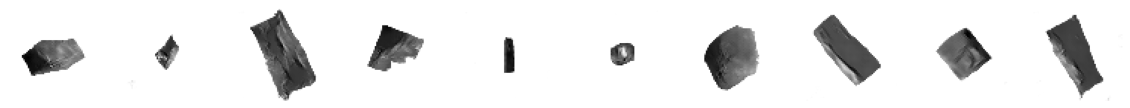

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0889 - g_loss: 9.0976
Epoch 233/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0667 - g_loss: 9.3477
Saved to ./output/generated_img_232.png


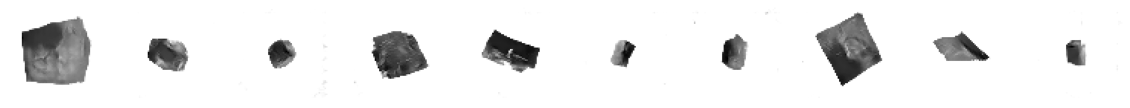

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0667 - g_loss: 9.3477
Epoch 234/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0784 - g_loss: 9.3900
Saved to ./output/generated_img_233.png


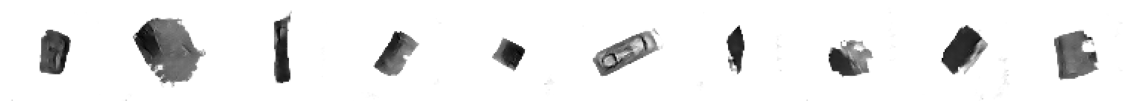

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0784 - g_loss: 9.3900
Epoch 235/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0670 - g_loss: 9.4495
Saved to ./output/generated_img_234.png


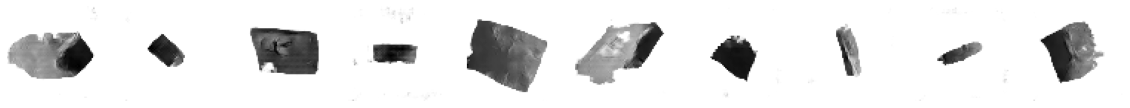

250/250 [==============================] - 38s 149ms/step - d_loss: 0.0670 - g_loss: 9.4495
Epoch 236/300
250/250 [==============================] - ETA: 0s - d_loss: 0.2823 - g_loss: 8.4544
Saved to ./output/generated_img_235.png


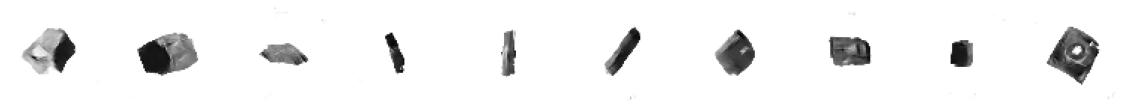

250/250 [==============================] - 38s 148ms/step - d_loss: 0.2823 - g_loss: 8.4544
Epoch 237/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0776 - g_loss: 9.1280
Saved to ./output/generated_img_236.png


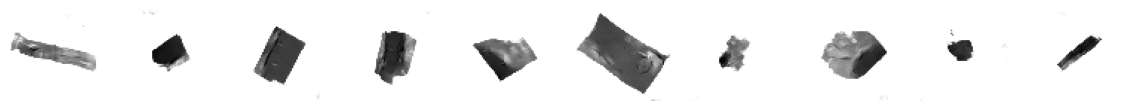

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0776 - g_loss: 9.1280
Epoch 238/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0314 - g_loss: 9.6216
Saved to ./output/generated_img_237.png


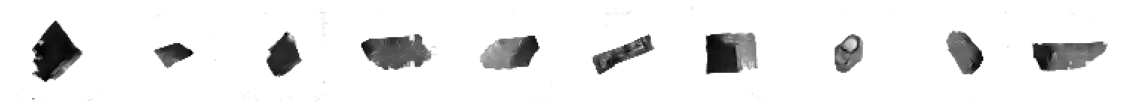

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0314 - g_loss: 9.6216
Epoch 239/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1276 - g_loss: 9.0569
Saved to ./output/generated_img_238.png


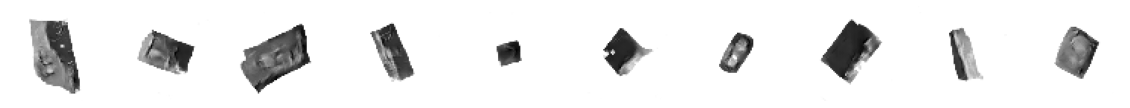

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1276 - g_loss: 9.0569
Epoch 240/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0277 - g_loss: 9.8553
Saved to ./output/generated_img_239.png


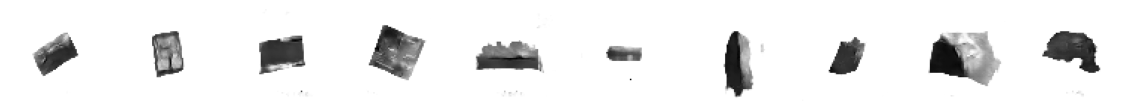

250/250 [==============================] - 38s 149ms/step - d_loss: 0.0277 - g_loss: 9.8553
Epoch 241/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0589 - g_loss: 9.6857
Saved to ./output/generated_img_240.png


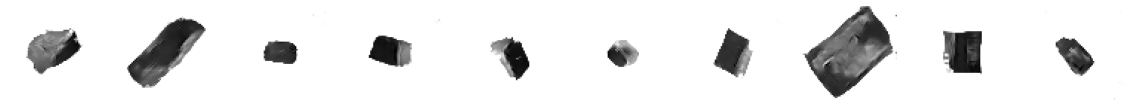

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0589 - g_loss: 9.6857
Epoch 242/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0549 - g_loss: 9.6082
Saved to ./output/generated_img_241.png


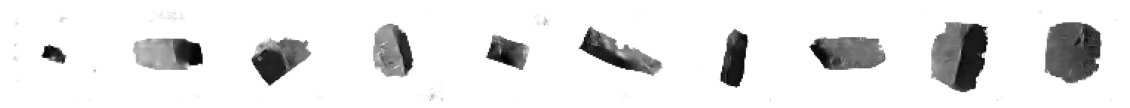

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0549 - g_loss: 9.6082
Epoch 243/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0425 - g_loss: 9.8893
Saved to ./output/generated_img_242.png


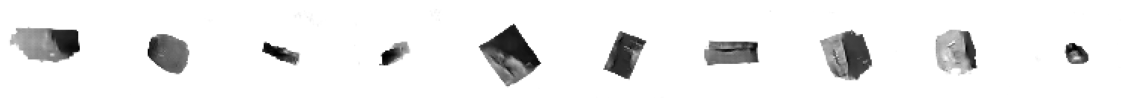

250/250 [==============================] - 38s 149ms/step - d_loss: 0.0425 - g_loss: 9.8893
Epoch 244/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1916 - g_loss: 8.8317
Saved to ./output/generated_img_243.png


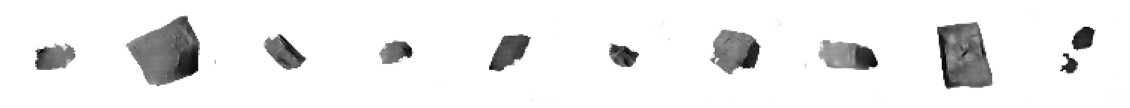

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1916 - g_loss: 8.8317
Epoch 245/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0433 - g_loss: 9.8482
Saved to ./output/generated_img_244.png


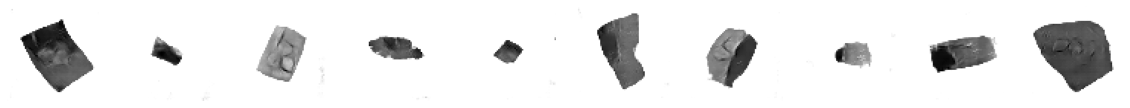

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0433 - g_loss: 9.8482
Epoch 246/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0299 - g_loss: 9.9903
Saved to ./output/generated_img_245.png


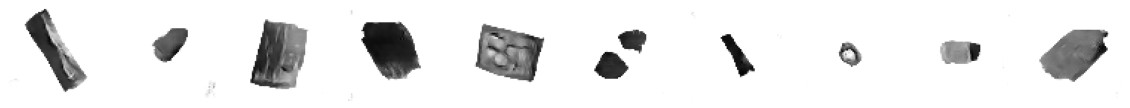

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0299 - g_loss: 9.9903
Epoch 247/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1758 - g_loss: 9.5235
Saved to ./output/generated_img_246.png


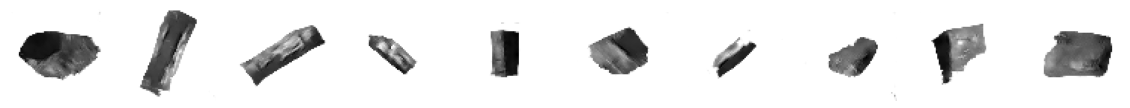

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1758 - g_loss: 9.5235
Epoch 248/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1070 - g_loss: 9.5502
Saved to ./output/generated_img_247.png


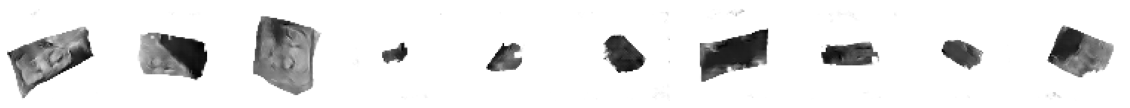

250/250 [==============================] - 38s 148ms/step - d_loss: 0.1070 - g_loss: 9.5502
Epoch 249/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0603 - g_loss: 9.7805
Saved to ./output/generated_img_248.png


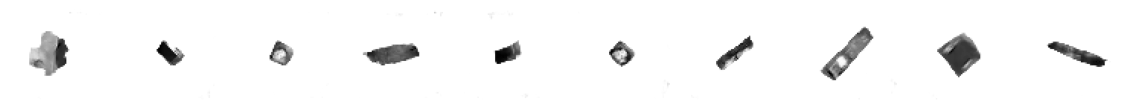

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0603 - g_loss: 9.7805
Epoch 250/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0297 - g_loss: 10.1840
Saved to ./output/generated_img_249.png


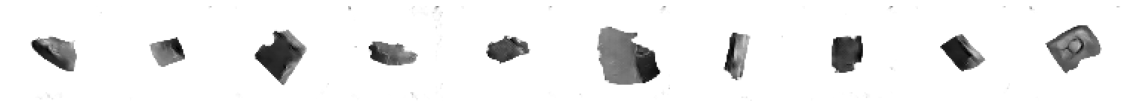

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0297 - g_loss: 10.1840
Epoch 251/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0834 - g_loss: 9.8682
Saved to ./output/generated_img_250.png


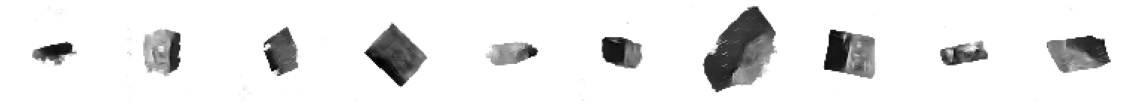

250/250 [==============================] - 38s 149ms/step - d_loss: 0.0834 - g_loss: 9.8682
Epoch 252/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0556 - g_loss: 10.0005
Saved to ./output/generated_img_251.png


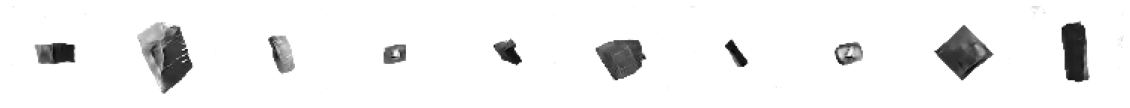

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0556 - g_loss: 10.0005
Epoch 253/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0702 - g_loss: 9.9771
Saved to ./output/generated_img_252.png


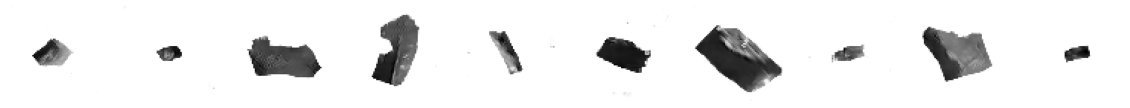

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0702 - g_loss: 9.9771
Epoch 254/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0503 - g_loss: 10.4136
Saved to ./output/generated_img_253.png


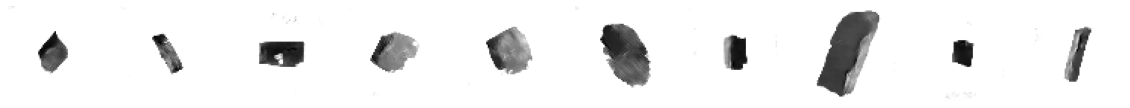

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0503 - g_loss: 10.4136
Epoch 255/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0471 - g_loss: 10.2185
Saved to ./output/generated_img_254.png


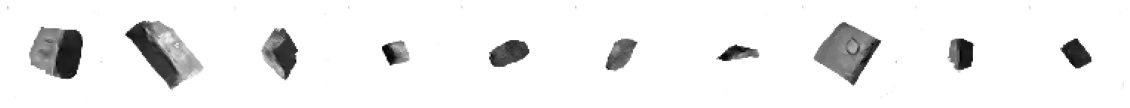

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0471 - g_loss: 10.2185
Epoch 256/300
250/250 [==============================] - ETA: 0s - d_loss: 0.1757 - g_loss: 9.8252
Saved to ./output/generated_img_255.png


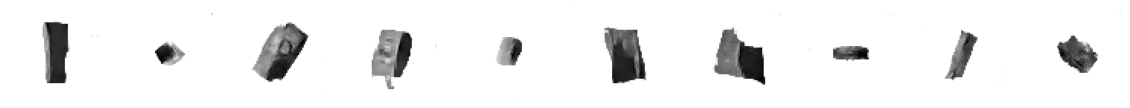

250/250 [==============================] - 38s 149ms/step - d_loss: 0.1757 - g_loss: 9.8252
Epoch 257/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0543 - g_loss: 10.3069
Saved to ./output/generated_img_256.png


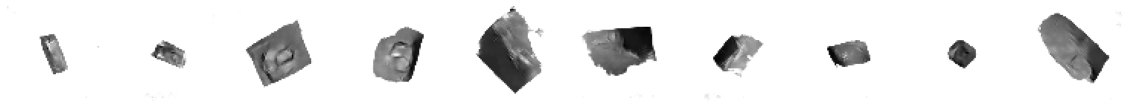

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0543 - g_loss: 10.3069
Epoch 258/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0850 - g_loss: 10.0536
Saved to ./output/generated_img_257.png


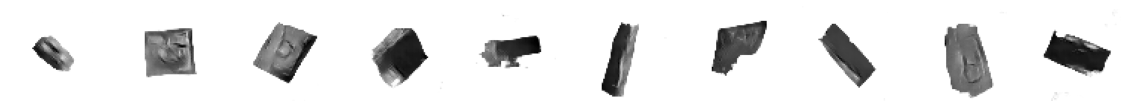

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0850 - g_loss: 10.0536
Epoch 259/300
250/250 [==============================] - ETA: 0s - d_loss: 0.0494 - g_loss: 10.3752
Saved to ./output/generated_img_258.png


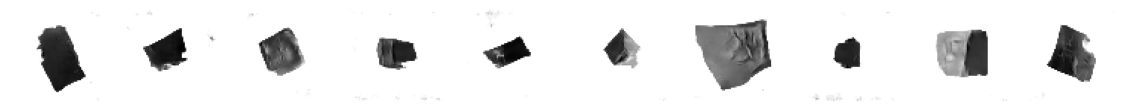

250/250 [==============================] - 38s 148ms/step - d_loss: 0.0494 - g_loss: 10.3752
Epoch 260/300
213/250 [========================>.....] - ETA: 5s - d_loss: 0.0385 - g_loss: 10.5308

KeyboardInterrupt: 

In [15]:
history = gan.fit(
    train, 
    epochs=EPOCHS, 
    # steps_per_epoch = 100, 
    initial_epoch = 164,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)

In [16]:
# Save the final models
generator.save("./models/generator")
discriminator.save("./models/discriminator")

2022-04-23 21:50:54.907089: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/generator/assets
INFO:tensorflow:Assets written to: ./models/discriminator/assets


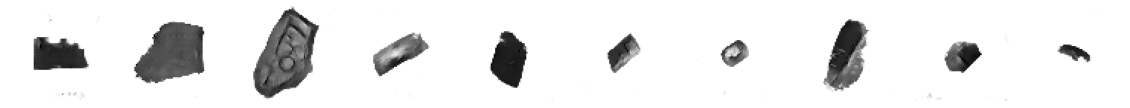